# KMeans Clustering of MNIST with (and without) PCA
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/judehunt/kmeans-pca/blob/main/kmeans-pca.ipynb)

In [1]:
# Import required packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn import datasets
import seaborn as sns
import numpy as np

In [2]:
# Load in our dataset
iris = datasets.load_iris()
X = pd.DataFrame(iris.data, columns=iris['feature_names'])
y = iris.target

In [3]:
# Let's see what the actual target names and feature names are
print(iris['target_names'])
print(iris['feature_names'])

['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


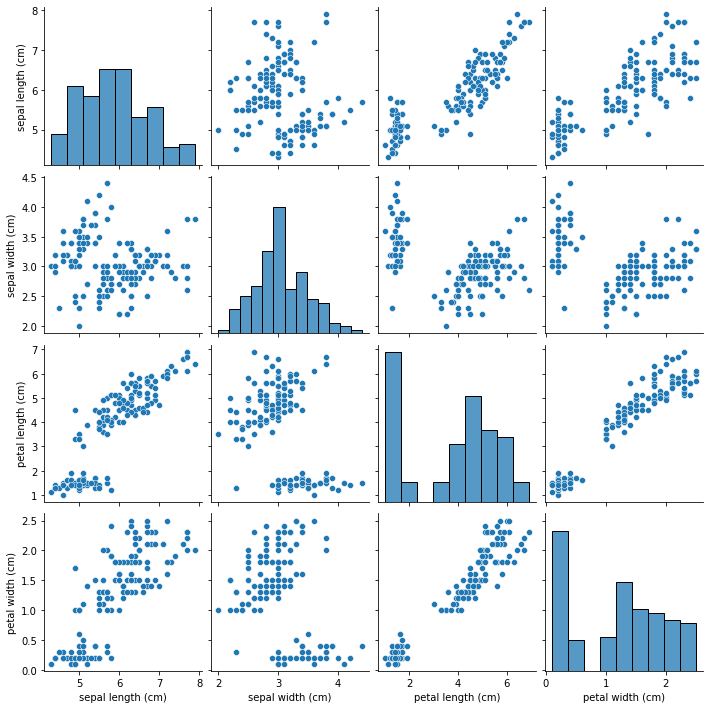

In [4]:
# Now let's have a quick look at the data 
# Pairplots show you the distribution of features as well as scatter plots across features in a dataset - great to see if there are obvious clusters!
sns.pairplot(X)

## K-Means Clustering
K-Means clustering is an unsupervised algorithm that tries to separate samples into groups of equal variance by minimising inertia. Inertia is the sum of squares, i.e. we're trying to make it so that all the points in the cluster are as close to the cluster's centroid as possible.

K-Means clustering randomly initialises n centroids (where n is determined by the user), and then assigns each sample to its nearest centroid (done by creating zones from the perpendicular bisecors between centroids). Following this, we create new centroids for each cluster by taking the mean values of all the samples in each cluster - this won't be the same centroid as before, but will be better because we're trying to minimise inertia! We then repeat (without the random initialisation) until the centroids don't move significantly between iterations.

To find out how many clusters we should use, we can try out a range of numbers of k-means models and have a look at the inertias for the clusters each one produces. We then want to identify the *elbow point* of the inertias - where it starts to level out. This is because we want to make the inertia small, but not so small that our model then overfits if we feed in new data - we don't want clusters with just one sample in them!

In [5]:
# Standardise data to have mean ~0 and variance 1
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

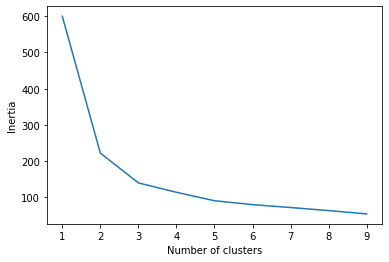

In [6]:
# Find number of clusters by identifying the elbow point of inertia
clusters = range(1, 10)
inertias = []

for cluster in clusters:
    # Create a Kmeans cluster
    kmeans = KMeans(n_clusters=cluster)

    # Fit to the samples
    kmeans.fit(X_std)

    # Append interias to list
    inertias.append(kmeans.inertia_)

plt.plot(clusters, inertias)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(clusters)
plt.show()

Elbow point at n=3 suggests we should use this as our number of clusters, which makes sense, because there are 3 species of flower

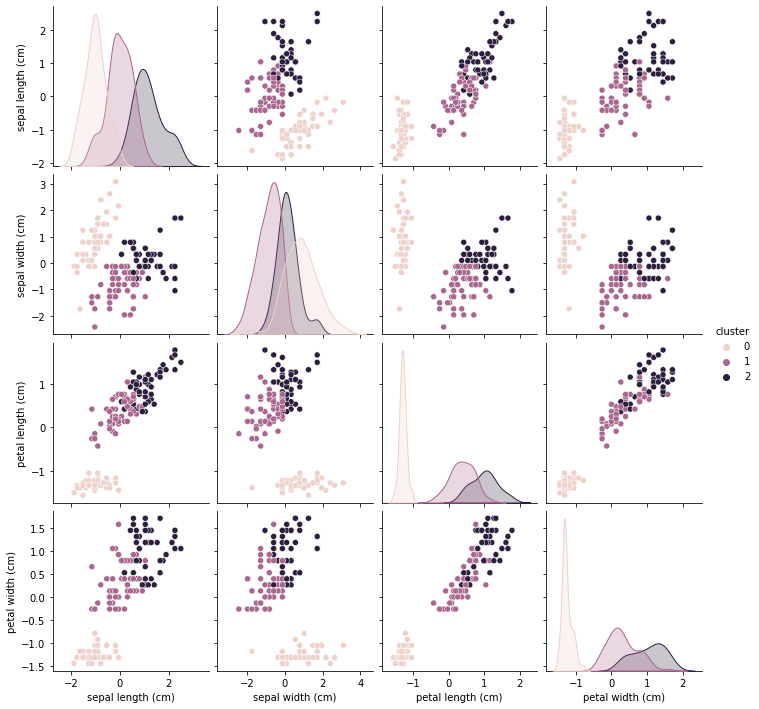

In [7]:
# Now let's run k-means for 3 clusters, and plot the clusters it predicts!
kmeans = KMeans(n_clusters=3, random_state=7)

kmeans.fit(X_std)

X_pred = pd.DataFrame(X_std, columns=iris['feature_names'])
X_pred['cluster'] = kmeans.labels_
sns.pairplot(X_pred, hue='cluster')

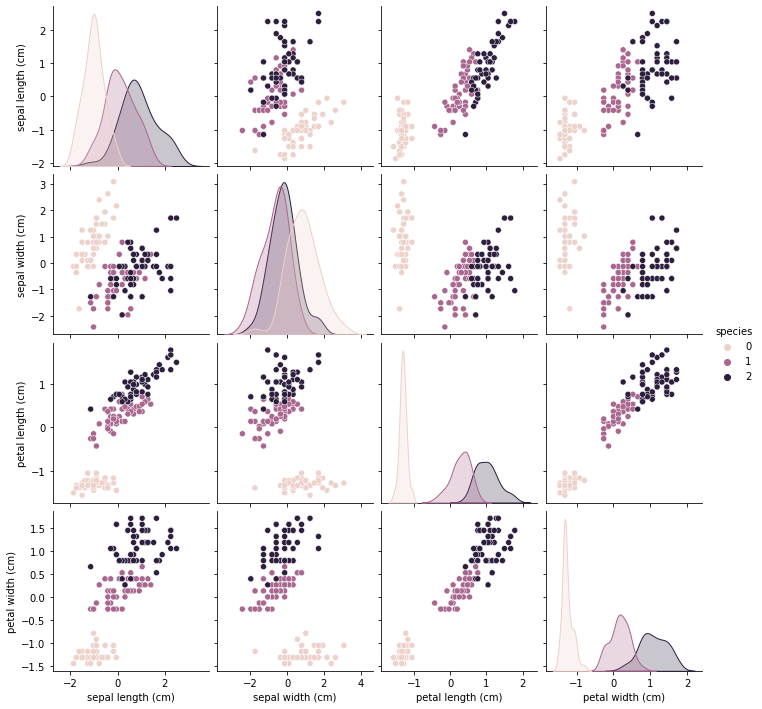

In [8]:
# Compare these clusters to the ground truth
X_target = pd.DataFrame(X_std,  columns=iris['feature_names'])
X_target['species'] = y

sns.pairplot(X_target, hue='species')

In [9]:
# And finish of with a numerical comparison between pred and target
accuracy_score(y, kmeans.labels_)

0.8133333333333334

## Principal Component Analysis
Principal component analysis is a technique to reconfigure the features of a dataset by constructing linear combinations of each feature such that the "Principal Components" that are created cover decreasing amounts of the variance of the dataset.

This means that the first constructed Principal Component will descibe the majority of the data, the second component will descibe the second largest variance, and the last constructed feature will descibe the least amount of the data. There will be an equal number of Principal Components constructed as there were in the original data.

This is particularly useful for high dimensional datasets, as the first few PCs will describe the most data, meaning that we can reduce the dimensionality of our dataset while still covering most of the variance of the data.

Note that PCA requires numerical, *normalised* data, as otherwise some features will have a larger variance than others.

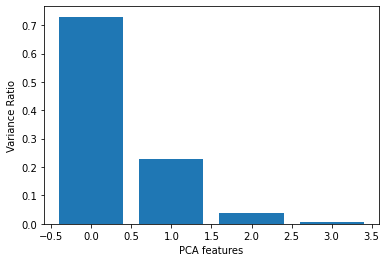

In [10]:
# Let's do the above kmeans clustering with PCA components instead
pca = PCA(n_components=len(X_std[0]))
principal_components = pca.fit_transform(X_std)

# Plot the principal components 
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('Variance Ratio')
plt.show()

pca_X = pd.DataFrame(principal_components)

Here we see that the majority of the data is actually well described by the first two principal componenets! So let's try doing the same kmeans clustering based solely on these two features

Text(0, 0.5, 'PCA 2')

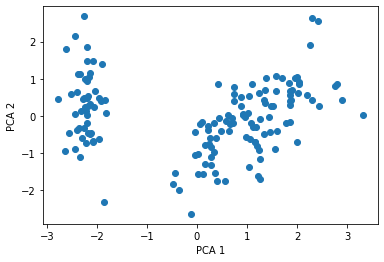

In [11]:
plt.scatter(pca_X[0], pca_X[1])
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

Accuracy score with PCA:  0.82


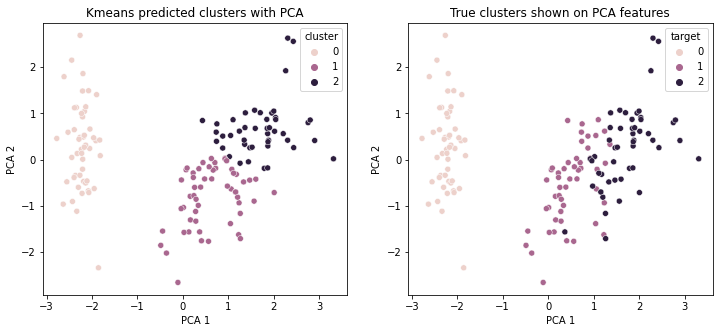

In [12]:
# First, create a KMeans model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=7)

# Fit that model
kmeans.fit(pca_X.iloc[:,:2])

# And use it to predict our clusters
pca_X_pred = pd.DataFrame(pca_X.iloc[:,:2])
pca_X_pred.columns=['PCA 1', 'PCA 2']
pca_X_pred['cluster'] = kmeans.labels_


# And compare this with our target data
pca_target = pd.DataFrame(pca_X.iloc[:,:2])
pca_target.columns=['PCA 1', 'PCA 2']
pca_target['target'] = y

# Let's plot the clusters side by side this time 

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the PCA, kmeans predicted clusters
sns.scatterplot(data=pca_X_pred, x='PCA 1', y='PCA 2', hue='cluster', ax=axes[0])
axes[0].set_title('Kmeans predicted clusters with PCA')

# And plot the target clusters
sns.scatterplot(data=pca_target, x='PCA 1', y='PCA 2', hue='target', ax=axes[1])
axes[1].set_title('True clusters shown on PCA features')

# And assess accuracy
print('Accuracy score with PCA: ', accuracy_score(y, pca_X_pred['cluster']))

We actually got a higher accuracy using PCA than we did without!